In [1]:
%load_ext autoreload
%autoreload 2
# from imports.networks import *
from imports.data import *
from imports.params import p
import matplotlib.pyplot as plt

# make spline

In [3]:
# p["soapfile"] = "halo_properties_0078.hdf5"
# p["simsize"] = "L2800N5040"
# p["snapshot"] = "flamingo_0078/flamingo_0078.hdf5"
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)

total nr halos in selection:  289849
nr inside mass selection:  322254
nr with nonzero luminosity:  563750


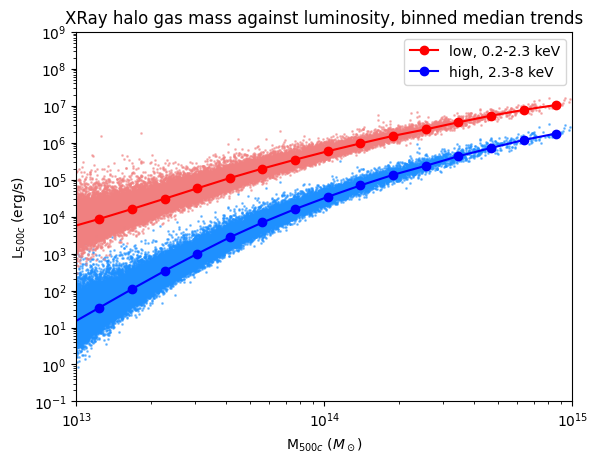

In [4]:
### get median binned mass per luminosity 
mass = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:]

luminosity = data.soap_file[f"{p['selection_type']}/XRayPhotonLuminosityWithoutRecentAGNHeating"][:]
# luminosity_selection_low = luminosity[:,0] < 1e45
# luminosity_selection_high = luminosity[:,1] < 1e45
mass_selection = np.logical_and(mass > 3e12, mass < 1e15)
nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

selection = mass_selection*nonzero#*luminosity_selection_low*luminosity_selection_high


flux_ratio, fov = get_flux_ratio(p)

mass = mass[selection]
luminosity = luminosity[selection]*flux_ratio*p["obs_time"]
print("total nr halos in selection: ", len(mass))
print("nr inside mass selection: ", np.sum(mass_selection))
print("nr with nonzero luminosity: ", np.sum(nonzero))


plt.scatter(mass, luminosity[:, 1], s=1, c="dodgerblue", alpha=0.5)
plt.scatter(mass, luminosity[:, 0], s=1, c="lightcoral", alpha=0.5)


bins = np.logspace(12.5, 15, 20)
masses = np.logspace(12.5, 15, 39)[1::2]

luminosities_low = []
# masses_low = []
luminosities_high = []
# masses_high = []
for i in range(len(bins)-1):
    indices = np.logical_and(mass > bins[i], mass < bins[i+1])

    luminosities_low.append(np.median(luminosity[indices,0]))
    # masses_low.append(np.median(mass[indices]))
    
    luminosities_high.append(np.median(luminosity[indices,1]))
    # masses_high.append(np.median(mass[indices]))


# print(flux_ratio)
# print(luminosities_high)
# plt.figure(figsize=(10, 10))
plt.plot(masses, luminosities_low, c="red", marker="o", label="low, 0.2-2.3 keV")
plt.plot(masses, luminosities_high, c="blue", marker="o", label="high, 2.3-8 keV")
plt.ylim(1e-1, 1e9)
plt.xlim(1e13, 1e15)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M$_{500c}$ $(M_\odot)$")
plt.ylabel("L$_{500c}$ (erg/s)")
plt.title("XRay halo gas mass against luminosity, binned median trends")
plt.legend()
plt.show()

[3.71533899 3.86035107 4.07080313 4.31005567 4.56420999 4.83472924
 5.11104719 5.40192175 5.68045898 5.95547554 6.21808984 6.4461696
 6.67552541 6.86691031 7.07579408 7.25604572 7.43580194 7.58699805
 7.74486721]


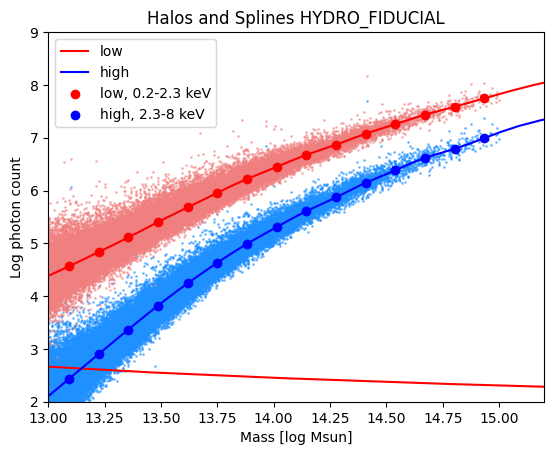

In [12]:
### get splines through these binned medians
from scipy.interpolate import CubicSpline
print(np.log10(luminosities_low))
spl_low = CubicSpline(np.log10(luminosities_low), np.log10(masses), bc_type=((1, 1), (2, 0.0)))
spl_high = CubicSpline(np.log10(luminosities_high), np.log10(masses), bc_type="natural")

x = np.linspace(-2, 9, 100)
plt.plot(spl_low(x), x, c="red", label="low")
plt.plot(spl_high(x), x, c="blue", label="high")
plt.scatter(np.log10(mass), np.log10(luminosity[:, 1]), s=1, c="dodgerblue", alpha=0.5)
plt.scatter(np.log10(mass), np.log10(luminosity[:, 0]), s=1, c="lightcoral", alpha=0.5)
plt.scatter(np.log10(masses), np.log10(luminosities_low), c="red", label="low, 0.2-2.3 keV")
plt.scatter(np.log10(masses), np.log10(luminosities_high), c="blue", label="high, 2.3-8 keV")
plt.xlim(13, 15.2)
plt.ylim(2, 9)
plt.xlabel("Mass [log Msun]")
plt.ylabel("Log photon count")
plt.title("Halos and Splines "+p["model"])
plt.legend()
plt.savefig("/home/tol/Documents/Thesis/plots/"+"spline_"+p_to_filename(p), dpi=200)
plt.show()

In [9]:
### save splines
filename = p_to_filename(p)
np.save(p['model_path'] + filename + "_spline_fit_low", spl_low, allow_pickle=True)
np.save(p['model_path'] + filename + "_spline_fit_high", spl_high, allow_pickle=True)


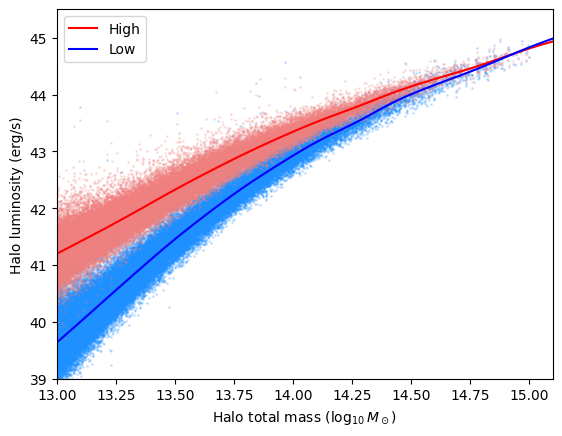

In [19]:
x = np.linspace(39, 45, 100)
filename = p_to_filename(p)
spl_low = np.load(p['model_path'] + filename + "_spline_fit_low.npy", allow_pickle=True)[()]
spl_high = np.load(p['model_path'] + filename + "_spline_fit_high.npy", allow_pickle=True)[()]

plt.plot(spl_low(x), x, c="red", label="High")
plt.plot(spl_high(x), x, c="blue", label="Low")

plt.scatter(np.log10(mass), np.log10(luminosity[:, 1]), s=1, c="dodgerblue", alpha=0.2)
plt.scatter(np.log10(mass), np.log10(luminosity[:, 0]), s=1, c="lightcoral", alpha=0.2)
# plt.scatter(np.log10(luminosities_low), np.log10(masses_low), c="red", alpha=0.5)
# plt.scatter(np.log10(luminosities_high), np.log10(masses_high), c="blue", alpha=0.5)
plt.xlim(13, 15.1)
plt.ylim(39, 45.5)
plt.xlabel(r"Halo total mass $(\log_{10}M_\odot)$")
plt.ylabel("Halo luminosity (erg/s)")
plt.legend()
plt.savefig("scaling relation fig", dpi=200)
plt.show()



# 2d spline

In [7]:
from scipy.interpolate import CloughTocher2DInterpolator
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)
mass = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:]

luminosity = data.soap_file[f"{p['selection_type']}/XRayLuminosityWithoutRecentAGNHeating"][:]
luminosity_selection_low = luminosity[:,0] < 1e45
luminosity_selection_high = luminosity[:,1] < 1e45
mass_selection = np.logical_and(mass > 1e12, mass < 1e15)
nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

selection = mass_selection*nonzero*luminosity_selection_low*luminosity_selection_high

mass = mass[selection]
luminosity = luminosity[selection]

In [81]:
x = np.log10(luminosity[:,0])
y = np.log10(luminosity[:,1])
z = np.log10(mass)
interp = CloughTocher2DInterpolator(list(zip(x, y)), z, tol=1e4)

In [54]:
# filename = p_to_filename(p)
# np.save(p['model_path'] + filename + "_scalingrelation", interp, allow_pickle=True)

In [56]:
X, Y = np.meshgrid(np.linspace(np.min(x), np.max(x), 500), np.linspace(np.min(y), np.max(y), 500))
Z = interp(X, Y)

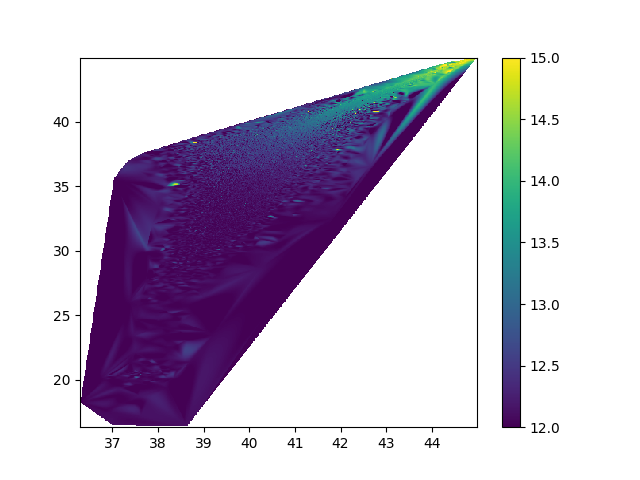

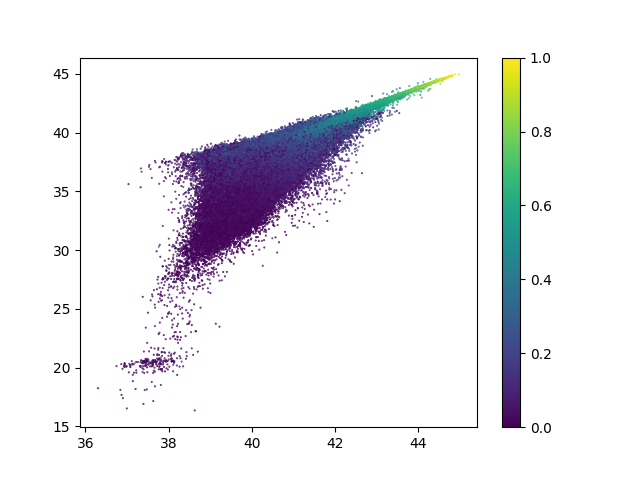

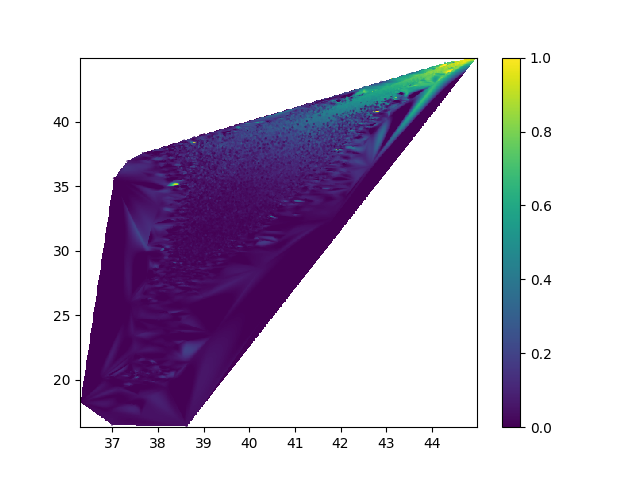

In [57]:
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=12, vmax=15)
plt.colorbar()
plt.show()
plt.figure()
plt.scatter(x, y, s=0.2, c=plt.cm.viridis((z - np.min(z))/np.max((z - np.min(z)))))
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=12, vmax=15)
plt.scatter(x, y, s=0.2, c=plt.cm.viridis((z - np.min(z))/np.max((z - np.min(z)))))
plt.colorbar()
plt.show()

In [87]:
### Hieronder voor zelf gemaakte binned grid

In [106]:
binsize = 0.2
binX = np.arange(np.min(x), np.max(x), binsize)
binY = np.arange(np.min(y), np.max(y), binsize)
mediangrid = np.empty((len(binX), len(binY)))
pointsX = []
pointsY = []
pointsZ = []
for i in range(len(binX)-1):
    for j in range(len(binY)-1):
        selectionX = np.logical_and(x > binX[i], x < binX[i+1])
        selectionY = np.logical_and(y > binY[j], y < binY[j+1])
        indices = np.logical_and(selectionX, selectionY)

        if np.sum(indices)>0:
            pointsX.append((binX[i]+binX[i+1])/2)
            pointsY.append((binY[j]+binY[j+1])/2)
            pointsZ.append(np.median(z[indices]))

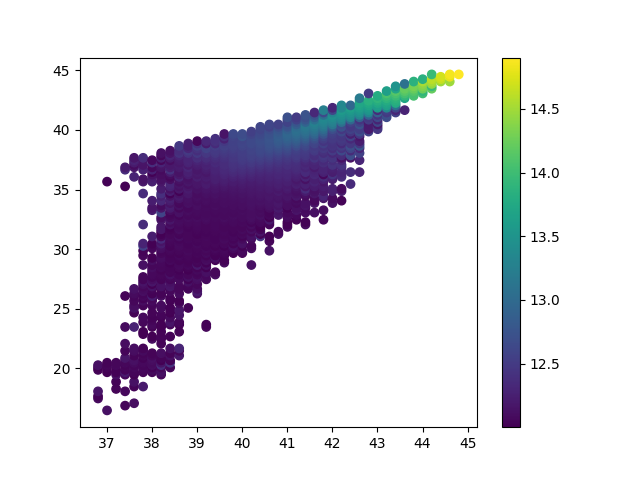

In [107]:
plt.figure()
plt.scatter(pointsX, pointsY, c=pointsZ)
plt.colorbar()
plt.show()

In [108]:
interp = CloughTocher2DInterpolator(list(zip(pointsX, pointsY)), pointsZ)
Z = interp(X, Y)

In [109]:
print(pointsZ)

[12.069917, 12.016326, 12.157356, 12.035221, 12.005872, 12.117971, 12.118681, 12.007709, 12.03285, 12.050431, 12.027849, 12.023011, 12.028723, 12.013623, 12.115833, 12.014035, 12.017672, 12.062712, 12.057841, 12.043737, 12.067376, 12.060284, 12.196319, 12.0441, 12.055211, 12.025978, 12.065917, 12.047934, 12.166986, 12.037793, 12.099828, 12.087042, 12.0309, 12.010903, 12.343923, 12.197034, 12.112967, 12.027411, 12.133333, 12.004027, 12.036012, 12.06286, 12.037366, 12.084944, 12.122918, 12.028723, 12.100568, 12.108505, 12.269447, 12.03436, 12.142162, 12.096853, 12.048768, 12.0420475, 12.089326, 12.129197, 12.280831, 12.177648, 12.083209, 12.210452, 12.274929, 12.161877, 12.204669, 12.025217, 12.050381, 12.06027, 12.043383, 12.061088, 12.059845, 12.012718, 12.048729, 12.026096, 12.089326, 12.034808, 12.020788, 12.011812, 12.056206, 12.064323, 12.026974, 12.099086, 12.022126, 12.059614, 12.03822, 12.113686, 12.083706, 12.051261, 12.107127, 12.153443, 12.036304, 12.047097, 12.124253, 12.050

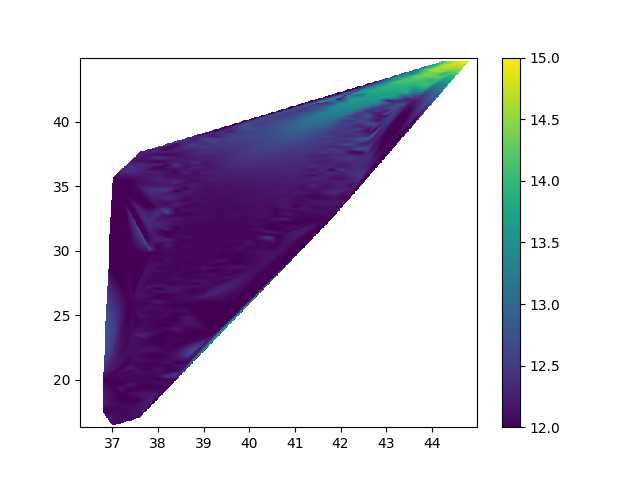

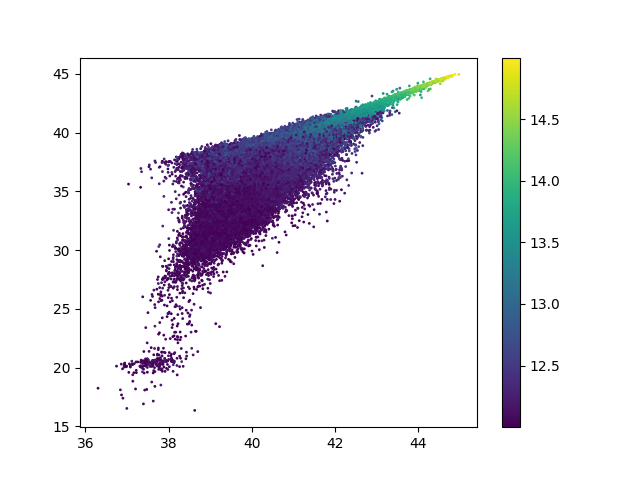

In [112]:
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=12, vmax=15)
plt.colorbar()
plt.show()
plt.figure()
plt.scatter(x, y, s=1, c=z)
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=12, vmax=15)
plt.scatter(x, y, s=1, c=z)
plt.colorbar()
plt.show()

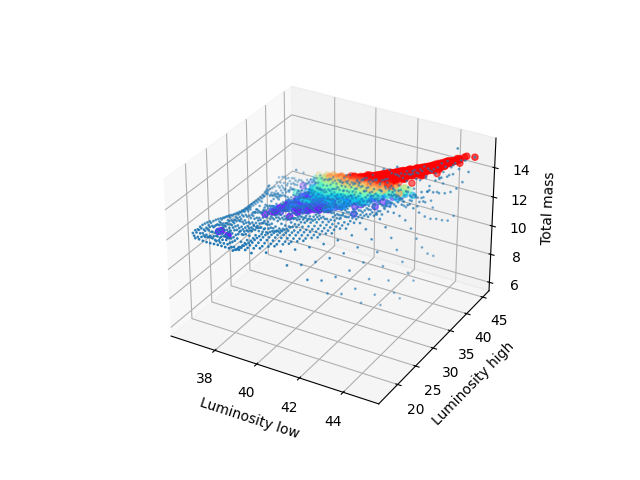

AttributeError: 'QuadMesh' object has no attribute 'do_3d_projection'

AttributeError: 'QuadMesh' object has no attribute 'do_3d_projection'

In [37]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z, s=1)
ax.set_xlabel("Luminosity low")
ax.set_ylabel("Luminosity high")
ax.set_zlabel("Total mass")

stepsize = 50
m = np.log10(mass[::stepsize])
llow = np.log10(luminosity[::stepsize,0])
lhigh = np.log10(luminosity[::stepsize,1])
ax.scatter(llow, lhigh, m, color=plt.cm.rainbow((m - np.min(m))))

plt.show()

# plot scaling relation

In [7]:
%matplotlib widget
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)

In [29]:
mass = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:]

luminosity = data.soap_file[f"{p['selection_type']}/XRayLuminosityWithoutRecentAGNHeating"][:]
luminosity_selection_low = luminosity[:,0] < 1e45
luminosity_selection_high = luminosity[:,1] < 1e45
mass_selection = np.logical_and(mass > 1e13, mass < 1e15)
nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

selection = mass_selection*nonzero*luminosity_selection_low*luminosity_selection_high

mass = mass[selection]
luminosity = luminosity[selection]

In [6]:
print(luminosity.shape)

(459084, 3)


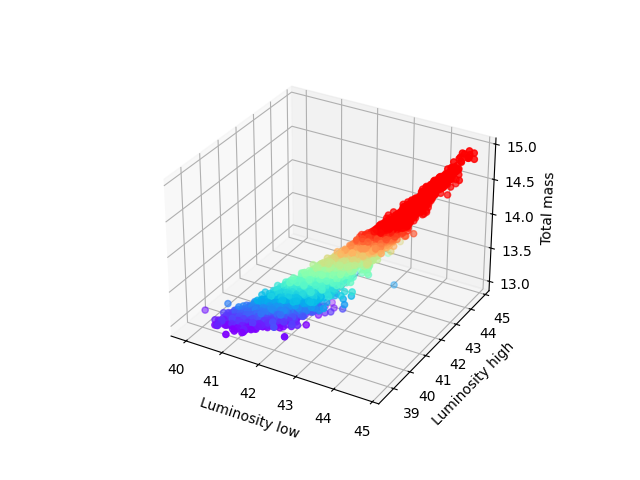

In [32]:
stepsize = 5
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
m = np.log10(mass[::stepsize])
llow = np.log10(luminosity[::stepsize,0])
lhigh = np.log10(luminosity[::stepsize,1])
ax.scatter(llow, lhigh, m, color=plt.cm.rainbow((m - np.min(m))))
ax.set_xlabel("Luminosity low")
ax.set_ylabel("Luminosity high")
ax.set_zlabel("Total mass")
plt.show()

In [345]:
# def predict_mass(l, band="low"):
#     poly = np.poly1d(np.load(f"/home/tol/Documents/Thesis/models/linear_fit_{band}_6.npy"))
#     return 10**poly(np.log10(l))

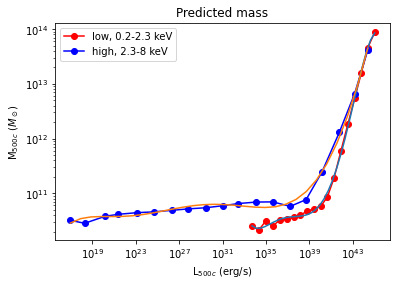

In [353]:
plt.plot(luminosities_low, gasmasses_low, c="red", marker="o", label="low, 0.2-2.3 keV")
plt.plot(luminosities_high, gasmasses_high, c="blue", marker="o", label="high, 2.3-8 keV")

testluminosities = np.logspace(np.log10(luminosities_low[0]), np.log10(luminosities_low[-1]), 30)
plt.plot(testluminosities, predict_mass(testluminosities, band="low"))

testluminosities = np.logspace(np.log10(luminosities_high[0]), np.log10(luminosities_high[-1]), 30)
plt.plot(testluminosities, predict_mass(testluminosities, band="high"))


plt.xscale("log")
plt.yscale("log")
plt.ylabel("M$_{500c}$ $(M_\odot)$")
plt.xlabel("L$_{500c}$ (erg/s)")
plt.title("Predicted mass")
plt.legend()
plt.show()

# Double power law function

In [9]:
def power_law(L, L0, M0, p1, p2):
    return np.append(p1*(L[L<L0]-L0)+M0, p2*(L[L>=L0]-L0)+M0)

def powerlaw2d(xy, L0_low, M0_low, p1_low, p2_low, L0_high, M0_high, p1_high, p2_high, A1, A2):
    x, y = xy
    fit_low = np.zeros(len(x))
    fit_low[x < L0_low] = p1_low * (x[x < L0_low] - L0_low)+M0_low
    fit_low[x >= L0_low] = p2_low * (x[x >= L0_low] - L0_low)+M0_low
    fit_high = np.zeros(len(y))
    fit_high[y < L0_high] = p1_high * (y[y < L0_high] - L0_high)+M0_high
    fit_high[y >= L0_high] = p2_high * (y[y >= L0_high] - L0_high)+M0_high
    return A1*fit_low + A2*fit_high

all_coeffs = {}
from scipy.optimize import curve_fit
for model in ["HYDRO_WEAK_AGN", "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_JETS_published", "HYDRO_STRONG_JETS_published"]:
# for model in ["HYDRO_FIDUCIAL"]:
    p["model"] = model
    data = Data(p)
    print(model)

    mass = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:]
    luminosity = data.soap_file[f"{p['selection_type']}/XRayPhotonLuminosityWithoutRecentAGNHeating"][:]
    mass_selection = np.logical_and(mass > 1e13, mass < 1e15)
    nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

    selection = mass_selection*nonzero

    flux_ratio, fov = get_flux_ratio(p)

    mass = np.log10(mass[selection])
    luminosity = np.log10(luminosity[selection]*flux_ratio*p["obs_time"])


    bins = np.linspace(13, 15, 20)
    masses = np.linspace(13, 15, 39)[1::2] #middles of bins

    luminosities_low = []
    var16_low = []
    var84_low = []
    luminosities_high = []
    var16_high = []
    var84_high = []

    for i in range(len(bins)-1):
        indices = np.logical_and(mass > bins[i], mass < bins[i+1])
        luminosities_low.append(np.median(luminosity[indices,0]))
        var16_low.append(np.percentile(luminosity[indices,0], 16))
        var84_low.append(np.percentile(luminosity[indices,0], 84))
        luminosities_high.append(np.median(luminosity[indices,1]))
        var16_high.append(np.percentile(luminosity[indices,1], 16))
        var84_high.append(np.percentile(luminosity[indices,1], 84))
    var16_low = np.array(luminosities_low) - np.array(var16_low)
    var84_low = np.array(var84_low) - np.array(luminosities_low)
    var16_high = np.array(luminosities_high) - np.array(var16_high)
    var84_high = np.array(var84_high) - np.array(luminosities_high)


    # bounds = ([2, 13, 0.1, 0.1], [8, 15, 1.5, 1.5])
    coeff_low, var = curve_fit(power_law, luminosities_low, masses, maxfev=300000, p0=[5, 13.5, 0.3, 0.7])
    print("L0, M0, p1, p2 for low energy band: ", coeff_low)
    coeff_high, var = curve_fit(power_law, luminosities_high, masses, maxfev=300000, p0=[5, 13.5, 0.3, 0.7])
    print("L0, M0, p1, p2 for high energy band: ", coeff_high)


    # binsize = 0.2
    # x = luminosity[:,0]
    # y = luminosity[:,1]
    # z = mass
    # binX = np.arange(np.min(x), np.max(x), binsize)
    # binY = np.arange(np.min(y), np.max(y), binsize)
    # mediangrid = np.empty((len(binX), len(binY)))
    # pointsX = []
    # pointsY = []
    # pointsZ = []
    # for i in range(len(binX)-1):
    #     for j in range(len(binY)-1):
    #         selectionX = np.logical_and(x > binX[i], x < binX[i+1])
    #         selectionY = np.logical_and(y > binY[j], y < binY[j+1])
    #         indices = np.logical_and(selectionX, selectionY)

    #         if np.sum(indices)>0:
    #             pointsX.append((binX[i]+binX[i+1])/2)
    #             pointsY.append((binY[j]+binY[j+1])/2)
    #             pointsZ.append(np.median(z[indices]))


    # datapoints2d = np.append(np.array(pointsX)[np.newaxis, :], np.array(pointsY)[np.newaxis, :], axis=0)
    datapoints2d = np.append(luminosity[:,0][np.newaxis, :], luminosity[:,1][np.newaxis, :], axis=0)
    bounds = ([2, 13, 0.1, 0.1, 2, 13, 0.1, 0.1, 0.3, 0.3], [8, 15, 1.5, 1.5, 8, 15, 1.5, 1.5, 0.7, 0.7])
    coeff2d, var = curve_fit(powerlaw2d, datapoints2d, mass, p0=[coeff_low[0], coeff_low[1], coeff_low[2], coeff_low[3], coeff_high[0], coeff_high[1], coeff_high[2], coeff_high[3], 0.5, 0.5])
    print("L0 low:", coeff2d[0])
    print("L0 high:", coeff2d[4])
    print()
    print("M0 low:", coeff2d[1])
    print("M0 high:", coeff2d[5])
    print()
    print("p1 low:", coeff2d[2])
    print("p1 high:", coeff2d[6])
    print()
    print("p2 low:", coeff2d[3])
    print("p2 high:", coeff2d[7])
    print()
    print("A1:", coeff2d[8])
    print("A2:", coeff2d[9])
    print()

    coeffdict = {}
    coeffdict["low"] = {}
    coeffdict["low"]["L0"] = coeff2d[0]
    coeffdict["low"]["M0"] = coeff2d[1]
    coeffdict["low"]["p1"] = coeff2d[2]
    coeffdict["low"]["p2"] = coeff2d[3]
    coeffdict["high"] = {}
    coeffdict["high"]["L0"] = coeff2d[4]
    coeffdict["high"]["M0"] = coeff2d[5]
    coeffdict["high"]["p1"] = coeff2d[6]
    coeffdict["high"]["p2"] = coeff2d[7]
    coeffdict["2d"] = {}
    coeffdict["2d"]["A1"] = coeff2d[8]
    coeffdict["2d"]["A2"] = coeff2d[9]

    all_coeffs[model] = coeffdict

import json
with open(p['model_path'] + "powerlaw_coeffs_photons.json", 'w') as filepath:
    json.dump(all_coeffs, filepath, indent=4)

HYDRO_WEAK_AGN
L0, M0, p1, p2 for low energy band:  [ 6.27126622 13.71915995  0.48059458  0.79174469]
L0, M0, p1, p2 for high energy band:  [ 4.97552983 13.72358661  0.30361609  0.57140361]
L0 low: 5.710987165567126
L0 high: 4.085626423356229

M0 low: 14.30408473169414
M0 high: 13.201654618369089

p1 low: -0.2642368436955614
p1 high: 0.6487068056720886

p2 low: -1.2081264497259638
p2 high: 1.7426134380589557

A1: 0.4925099470789396
A2: 0.48089498102631295

HYDRO_FIDUCIAL
L0, M0, p1, p2 for low energy band:  [ 6.55647215 14.0456032   0.48041216  0.7311763 ]
L0, M0, p1, p2 for high energy band:  [ 5.20651739 13.92493435  0.30494098  0.54388921]
L0 low: 6.196377518880929
L0 high: 2.6636562968073467

M0 low: 12.389852790530977
M0 high: 14.132967004516424

p1 low: -0.11928095557704173
p1 high: 0.309433104941984

p2 low: 0.36069482019708987
p2 high: 0.6795737296243681

A1: 0.4756287886835794
A2: 0.5057243635019469

HYDRO_STRONG_AGN
L0, M0, p1, p2 for low energy band:  [ 6.6220341  14.1755772

# double power law tests

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


total nr halos in selection:  80999
nr inside mass selection:  80999
nr with nonzero luminosity:  563750


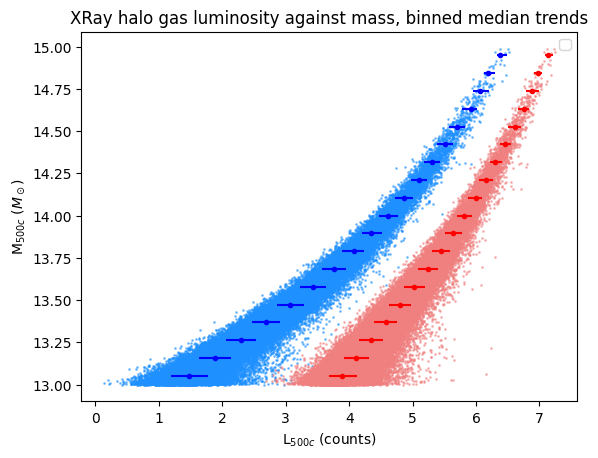

In [2]:
from scipy.optimize import curve_fit
p["model"] = "HYDRO_FIDUCIAL"
p["redshift"] = 0.15
data = Data(p)

mass = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:]
luminosity = data.soap_file[f"{p['selection_type']}/XRayPhotonLuminosityWithoutRecentAGNHeating"][:]
mass_selection = np.logical_and(mass > 1e13, mass < 1e15)
nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

selection = mass_selection*nonzero

flux_ratio, fov = get_flux_ratio(p)

mass = np.log10(mass[selection])
luminosity = np.log10(luminosity[selection]*flux_ratio*p["obs_time"])
print("total nr halos in selection: ", len(mass))
print("nr inside mass selection: ", np.sum(mass_selection))
print("nr with nonzero luminosity: ", np.sum(nonzero))


bins = np.linspace(13, 15, 20)
masses = np.linspace(13, 15, 39)[1::2] #middles of bins

luminosities_low = []
var16_low = []
var84_low = []
luminosities_high = []
var16_high = []
var84_high = []

for i in range(len(bins)-1):
    indices = np.logical_and(mass > bins[i], mass < bins[i+1])
    luminosities_low.append(np.median(luminosity[indices,0]))
    var16_low.append(np.percentile(luminosity[indices,0], 16))
    var84_low.append(np.percentile(luminosity[indices,0], 84))
    luminosities_high.append(np.median(luminosity[indices,1]))
    var16_high.append(np.percentile(luminosity[indices,1], 16))
    var84_high.append(np.percentile(luminosity[indices,1], 84))
var16_low = np.array(luminosities_low) - np.array(var16_low)
var84_low = np.array(var84_low) - np.array(luminosities_low)
var16_high = np.array(luminosities_high) - np.array(var16_high)
var84_high = np.array(var84_high) - np.array(luminosities_high)

plt.scatter(luminosity[:, 1], mass, s=1, c="dodgerblue", alpha=0.5)
plt.scatter(luminosity[:, 0], mass, s=1, c="lightcoral", alpha=0.5)
plt.errorbar(luminosities_low, masses, xerr=[var16_low, var84_low], c="red", ls="none", marker=".")
plt.errorbar(luminosities_high, masses, xerr=[var16_high, var84_high], c="blue", ls="none", marker=".")

# plt.ylim(1e-1, 1e9)
# plt.xscale("log")
# plt.yscale("log")
plt.ylabel("M$_{500c}$ $(M_\odot)$")
plt.xlabel("L$_{500c}$ (counts)")
plt.title("XRay halo gas luminosity against mass, binned median trends")
plt.legend()
plt.show()

In [5]:
print(var16_high)
print(var84_high)
print(var16_low)

[0.28758724 0.25708585 0.23835979 0.21819261 0.20885231 0.20240865
 0.19261361 0.17545493 0.15242227 0.14121433 0.14000988 0.12755408
 0.11686752 0.12309611 0.12537016 0.14685633 0.09822911 0.07126494
 0.04784444]
[0.29842161 0.25605371 0.23100193 0.21823846 0.2149482  0.20898543
 0.18725844 0.17029611 0.16600669 0.14992404 0.13748197 0.12738897
 0.12403392 0.1276648  0.11914344 0.08467556 0.14306191 0.10004879
 0.10774594]
[0.21272524 0.18975558 0.18366836 0.17689033 0.17060272 0.15953419
 0.15169005 0.13800739 0.12493874 0.11471558 0.11128592 0.10351595
 0.08831118 0.08654443 0.09651746 0.09411926 0.08267302 0.05983216
 0.04115974]


In [3]:
def power_law(L, L0, M0, p1, p2):
    return np.append(p1*(L[L<L0]-L0)+M0, p2*(L[L>=L0]-L0)+M0)

/var/tmp/tol/ipykernel_3650480/672557218.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff_low, var = curve_fit(power_law, luminosity[:,0], mass, maxfev=3000)


[-4.60691113  9.95957408  3.25090357  0.37532704]
[3.53586921e+01 2.21118794e+01 2.65942976e-01 2.72047321e-02]


/var/tmp/tol/ipykernel_3650480/672557218.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff_high, var = curve_fit(power_law, luminosity[:, 1], mass, maxfev=3000)


NameError: name 'masses' is not defined

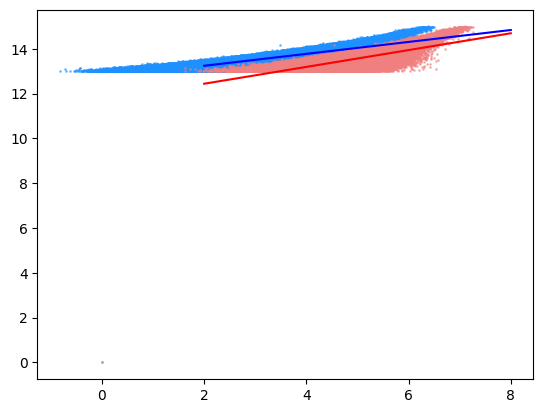

In [6]:
# L_sample = np.logspace(48, 54, 1000)
from scipy.optimize import curve_fit
L_sample = np.linspace(2, 8, 1000)
plt.scatter(luminosity[:, 1], mass, s=1, c="dodgerblue", alpha=0.5)
plt.scatter(luminosity[:, 0], mass, s=1, c="lightcoral", alpha=0.5)

# coeff_low, var = curve_fit(power_law, luminosities_low, masses, maxfev=30000, sigma=var16_low+var84_low, p0=[5, 13.5, 0.3, 0.7])
# coeff_low, var = curve_fit(power_law, luminosities_low, masses, maxfev=300000, p0=[5, 13.5, 0.3, 0.7])
coeff_low, var = curve_fit(power_law, luminosity[:,0], mass, maxfev=3000)
print(coeff_low)
plt.plot(L_sample, power_law(L_sample, coeff_low[0], coeff_low[1], coeff_low[2], coeff_low[3]), label="Low energy band", c="red")
# coeff_high, var = curve_fit(power_law, luminosities_high, masses, maxfev=30000, sigma=var16_high+var84_high, p0=[5, 13.5, 0.3, 0.7])
# coeff_high, var = curve_fit(power_law, luminosities_high, masses, maxfev=300000, p0=[5, 13.5, 0.3, 0.7])
coeff_high, var = curve_fit(power_law, luminosity[:, 1], mass, maxfev=3000)
print(coeff_high)
plt.plot(L_sample, power_law(L_sample, coeff_high[0], coeff_high[1], coeff_high[2], coeff_high[3]), label="High energy band", c="blue")
plt.errorbar(luminosities_low, masses, xerr=[var16_low, var84_low], c="red", ls="none", marker=".")
plt.errorbar(luminosities_high, masses, xerr=[var16_high, var84_high], c="blue", ls="none", marker=".")

# plt.xscale("log")
# plt.yscale("log")
plt.ylim(12.5, 15.5)
plt.ylabel("M$_{500c}$ $(M_\odot)$")
plt.xlabel("L$_{500c}$ (erg/s)")
plt.title("XRay halo gas mass against luminosity, binned median trends")
plt.legend()
plt.show()

In [5]:
spl_low = np.load(f"{p['model_path']}/{p_to_filename(p)}_spline_fit_low.npy", allow_pickle=True)[()]
spl_high = np.load(f"{p['model_path']}/{p_to_filename(p)}_spline_fit_high.npy", allow_pickle=True)[()]

plt.scatter(luminosity[:, 1], mass, s=1, c="dodgerblue", alpha=0.5)
plt.scatter(luminosity[:, 0], mass, s=1, c="lightcoral", alpha=0.5)
plt.plot(L_sample, power_law(L_sample, coeff_low[0], coeff_low[1], coeff_low[2], coeff_low[3]), label="Low energy band", c="red")
plt.plot(L_sample, power_law(L_sample, coeff_high[0], coeff_high[1], coeff_high[2], coeff_high[3]), label="High energy band", c="blue")
plt.errorbar(luminosities_low, masses, xerr=[var16_low, var84_low], c="red", ls="none", marker=".")
plt.errorbar(luminosities_high, masses, xerr=[var16_high, var84_high], c="blue", ls="none", marker=".")
plt.plot(L_sample, spl_low((L_sample)), label="Low energy band", c="red", ls="dashed")
plt.plot(L_sample, spl_high((L_sample)), label="High energy band", c="blue", ls="dashed")
# plt.xscale("log")
# plt.yscale("log")
plt.ylim(12.8, 15.1)
plt.ylabel("M$_{500c}$ $(M_\odot)$")
plt.xlabel("L$_{500c}$ (erg/s)")
plt.title("XRay halo gas mass against luminosity, binned median trends")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/tol/Documents/Thesis/models//L1000N1800_HYDRO_FIDUCIAL_SO_500crit_res64_z015_spline_fit_low.npy'

In [7]:
def powerlaw2d(xy, L0_low, p1_low, p2_low, L0_high, p1_high, p2_high, M0):
    x, y = xy
    fit_low = np.zeros(len(x))
    fit_low[x < L0_low] = p1_low * (x[x < L0_low] - L0_low)
    fit_low[x >= L0_low] = p2_low * (x[x >= L0_low] - L0_low)
    fit_high = np.zeros(len(y))
    fit_high[y < L0_high] = p1_high * (y[y < L0_high] - L0_high)
    fit_high[y >= L0_high] = p2_high * (y[y >= L0_high] - L0_high)
    return fit_low + fit_high + M0

In [21]:
datapoints2d = np.append(luminosity[1:,0][np.newaxis, :], luminosity[1:,1][np.newaxis, :], axis=0)
bounds = ([4, 13, 0.1, 0.1, 2, 13, 0.1, 0.1, 0.3, 0.3], [7, 15, 1.0, 1.0, 6, 15, 1.0, 1.0, 0.7, 0.7])
coeff2d, var = curve_fit(powerlaw2d, datapoints2d, mass[1:], sigma=np.mean([0.05])/4, p0=[5, coeff_low[2], coeff_low[3], 5, coeff_high[2], coeff_high[3], 14])
print(coeff2d)
print()
print("L0 low:", coeff2d[0])
print("L0 high:", coeff2d[3])
print()
print("M0: ", coeff2d[6])
# print("M0 low:", coeff2d[1])
# print("M0 high:", coeff2d[5])
print()
print("p1 low:", coeff2d[1])
print("p1 high:", coeff2d[4])
print()
print("p2 low:", coeff2d[2])
print("p2 high:", coeff2d[5])
print()
# print("A1:", coeff2d[8])
# print("A2:", coeff2d[9])


[ 4.19208482 -0.08927289 -0.36307856  2.25486204  0.21398304  0.56665437
 13.26903931]

L0 low: 4.1920848213741975
L0 high: 2.254862036703458

M0:  13.269039312023088

p1 low: -0.08927288996979894
p1 high: 0.21398303774160052

p2 low: -0.3630785572562407
p2 high: 0.5666543706263629



In [60]:
predictions = powerlaw2d(datapoints2d, coeff2d[0], coeff2d[1], coeff2d[2], coeff2d[3], coeff2d[4], coeff2d[5], coeff2d[6])
print(predictions)
print(mass)


[14.49576701 14.50942211 14.39120796 ... 12.99908421 13.04723277
 13.02117618]
[14.574591 14.505838 14.433457 ... 13.001432 13.002175 13.002917]


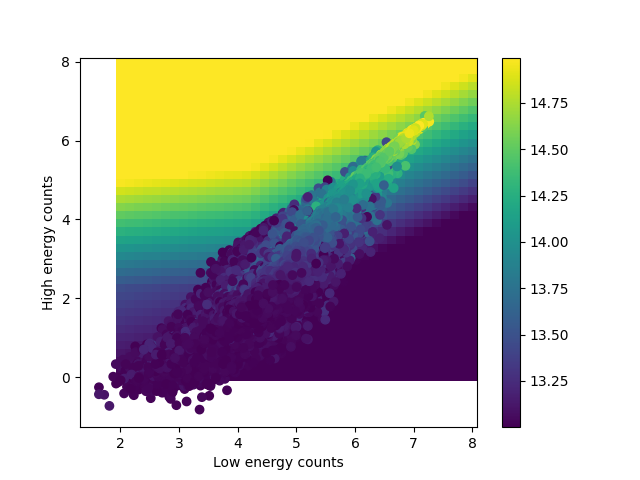

In [22]:
nrevals = 40

X, Y = np.meshgrid(np.linspace(2, 8, nrevals), np.linspace(0, 8, nrevals))
XY = np.append(X.flatten()[np.newaxis, :], Y.flatten()[np.newaxis, :], axis=0)
Z = powerlaw2d(XY, coeff2d[0], coeff2d[1], coeff2d[2], coeff2d[3], coeff2d[4], coeff2d[5], coeff2d[6]).reshape(nrevals, nrevals)
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=13, vmax=15)
plt.scatter(luminosity[1:,0], luminosity[1:,1], c=mass[1:])
plt.colorbar()
plt.xlabel("Low energy counts")
plt.ylabel("High energy counts")
plt.show()

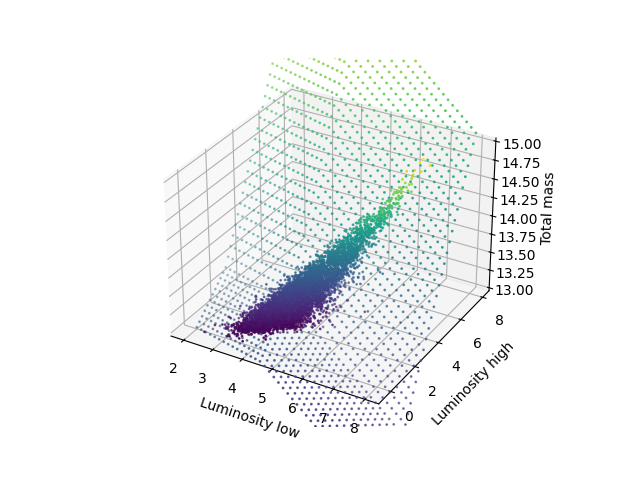

In [24]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d', alpha=0.2)
ax.scatter(X, Y, Z, s=1, c=Z)
ax.scatter(luminosity[1::100,0], luminosity[1::100,1], mass[1::100], s=1, c=mass[1::100])

ax.set_xlabel("Luminosity low")
ax.set_ylabel("Luminosity high")
ax.set_zlim(13, 15)
ax.set_zlabel("Total mass")
plt.show()

In [49]:
binsize = 0.2
x = luminosity[:,0]
y = luminosity[:,1]
z = mass
binX = np.arange(np.min(x), np.max(x), binsize)
binY = np.arange(np.min(y), np.max(y), binsize)
mediangrid = np.empty((len(binX), len(binY)))
pointsX = []
pointsY = []
pointsZ = []
sigma = []
for i in range(len(binX)-1):
    for j in range(len(binY)-1):
        selectionX = np.logical_and(x > binX[i], x < binX[i+1])
        selectionY = np.logical_and(y > binY[j], y < binY[j+1])
        indices = np.logical_and(selectionX, selectionY)

        if np.sum(indices)>0:
            pointsX.append((binX[i]+binX[i+1])/2)
            pointsY.append((binY[j]+binY[j+1])/2)
            pointsZ.append(np.median(z[indices]))
            sigma.append(1/np.sum(indices))


### equal weight median fit. two points per luminosity bin
binsize=0.1
binZ = np.arange(13, 15, binsize)
pointsX = []
pointsY = []
pointsZ = []
sigma = []
for i in range(len(binZ)-1):
    indices = np.logical_and(z > binZ[i], z < binZ[i+1])

    if np.sum(indices)>0:
        pointsX.append(np.mean(x[indices]))
        pointsY.append(np.mean(y[indices]))
        pointsZ.append((binZ[i] + binZ[i+1])/2)
        sigma.append(1/np.sqrt(np.sum(indices)))


In [40]:
print(sigma)

[1.0, 1.0, 0.3333333333333333, 0.25, 1.0, 0.5, 0.125, 0.2, 0.5, 0.5, 0.5, 0.2, 0.07142857142857142, 0.03333333333333333, 0.02040816326530612, 0.0625, 0.2, 1.0, 1.0, 0.5, 0.02564102564102564, 0.00641025641025641, 0.0044444444444444444, 0.005747126436781609, 0.01694915254237288, 0.125, 1.0, 0.5, 0.03125, 0.004975124378109453, 0.0014388489208633094, 0.0009025270758122744, 0.0014792899408284023, 0.004739336492890996, 0.02631578947368421, 0.14285714285714285, 1.0, 0.1111111111111111, 0.010309278350515464, 0.001841620626151013, 0.0005252100840336134, 0.00035014005602240897, 0.0005099439061703213, 0.0016286644951140066, 0.009900990099009901, 0.1, 0.25, 1.0, 0.3333333333333333, 0.047619047619047616, 0.006711409395973154, 0.001451378809869376, 0.00047505938242280285, 0.00027085590465872155, 0.00027442371020856203, 0.0006321112515802782, 0.0033333333333333335, 0.02564102564102564, 0.25, 0.5, 0.16666666666666666, 0.030303030303030304, 0.008064516129032258, 0.0024271844660194173, 0.000851063829787

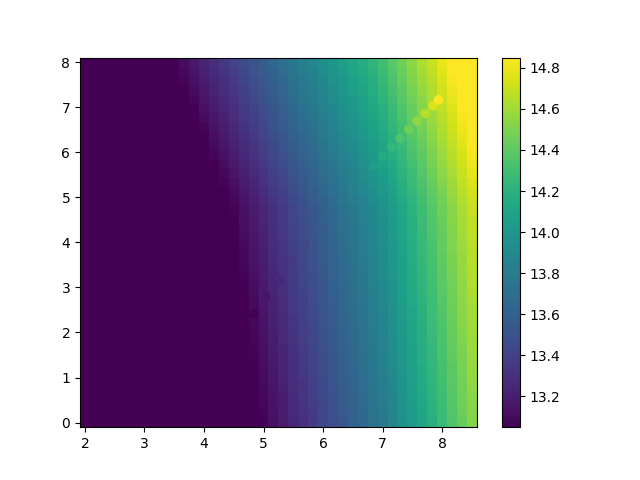

In [52]:
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=13, vmax=15)
plt.scatter(pointsX, pointsY, c=pointsZ)
plt.colorbar()
plt.show()

In [50]:
datapoints2d = np.append(np.array(pointsX)[np.newaxis, :], np.array(pointsY)[np.newaxis, :], axis=0)
coeff2d, var = curve_fit(powerlaw2d, datapoints2d, pointsZ, sigma=sigma, p0=[coeff_low[0], coeff_low[2], coeff_low[3], coeff_high[0], coeff_high[2], coeff_high[3], coeff_low[1]/2+coeff_high[1]/2])
print(coeff2d)
print()
print("L0 low:", coeff2d[0])
print("L0 high:", coeff2d[3])
print()
print("M0: ", coeff2d[6])
print()
print("p1 low:", coeff2d[1])
print("p1 high:", coeff2d[4])
print()
print("p2 low:", coeff2d[2])
print("p2 high:", coeff2d[5])

[ 6.93949453  0.39341408  0.54648842  4.7296733   0.04202076  0.11541874
 13.975868  ]

L0 low: 6.9394945275623705
L0 high: 4.729673301900409

M0:  13.975867995336731

p1 low: 0.39341408226248925
p1 high: 0.042020762488520935

p2 low: 0.546488416837578
p2 high: 0.11541873630650701


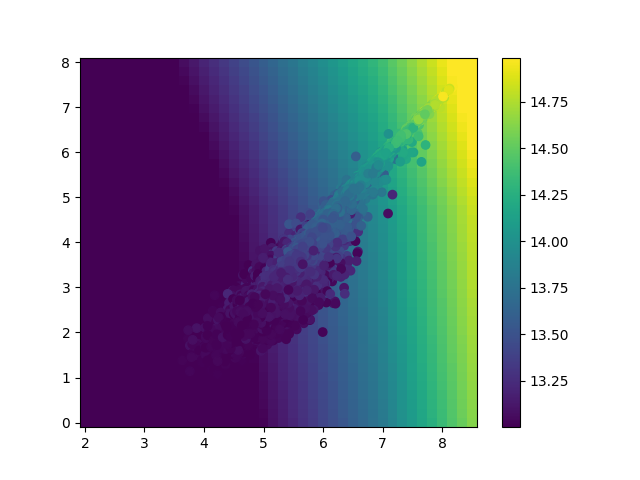

In [58]:
nrevals = 40

X, Y = np.meshgrid(np.linspace(2, 8.5, nrevals), np.linspace(0, 8, nrevals))
XY = np.append(X.flatten()[np.newaxis, :], Y.flatten()[np.newaxis, :], axis=0)
Z = powerlaw2d(XY, coeff2d[0], coeff2d[1], coeff2d[2], coeff2d[3], coeff2d[4], coeff2d[5], coeff2d[6]).reshape(nrevals, nrevals)
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=13, vmax=15)
plt.scatter(luminosity[:,0], luminosity[:,1], c=mass)
plt.colorbar()
plt.show()

/var/tmp/tol/ipykernel_3363457/1606225891.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


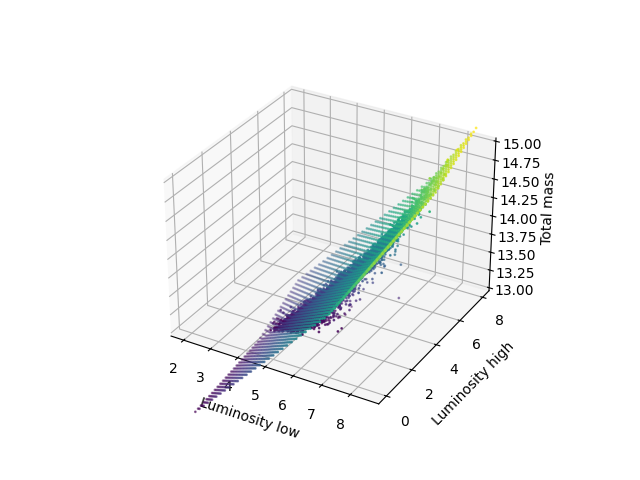

In [54]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d', alpha=0.2)
ax.scatter(X, Y, Z, s=1, c=Z)
ax.scatter(luminosity[::10,0], luminosity[::10,1], mass[::10], s=1, c=mass[::10])

ax.set_xlabel("Luminosity low")
ax.set_ylabel("Luminosity high")
ax.set_zlim(13, 15)
ax.set_zlabel("Total mass")
plt.show()

In [15]:
L_sample = np.linspace(2, 8, 1000)
plt.scatter(luminosity[:, 1], mass, s=1, c="dodgerblue", alpha=0.5)
plt.scatter(luminosity[:, 0], mass, s=1, c="lightcoral", alpha=0.5)

print(coeff2d[:4])
plt.plot(L_sample,power_law(L_sample, coeff2d[0], coeff2d[1], coeff2d[2], coeff2d[3]), label="Low energy band", c="red")
print(coeff2d[4:8])
plt.plot(L_sample,power_law(L_sample, coeff2d[4], coeff2d[5], coeff2d[6], coeff2d[7]), label="High energy band", c="blue")
plt.errorbar(luminosities_low, masses, xerr=[var16_low, var84_low], c="red", ls="none", marker=".")
plt.errorbar(luminosities_high, masses, xerr=[var16_high, var84_high], c="blue", ls="none", marker=".")
plt.plot(L_sample,coeff2d[8]*power_law(L_sample, coeff2d[0], coeff2d[1], coeff2d[2], coeff2d[3]) + coeff2d[9]*power_law(L_sample, coeff2d[4], coeff2d[5], coeff2d[6], coeff2d[7]), label="combined", c="purple")
# print("normalisations: ", coeff2d[8:])
# plt.xscale("log")
# plt.yscale("log")
# plt.ylim(12.5, 15.5)
plt.ylabel("M$_{500c}$ $(M_\odot)$")
plt.xlabel("L$_{500c}$ (erg/s)")
plt.title("XRay halo gas mass against luminosity, binned median trends")
plt.legend()
plt.show()

NameError: name 'np' is not defined

In [13]:
def powerlawlog(L, L0, M0, p1, p2):
    return p1*(L-L0) + p2*(L+M0)


coeff_low, var = curve_fit(powerlawlog, luminosities_low, masses, maxfev=300000, p0=[5, 13.5, 0.3, 0.7])
coeff_high, var = curve_fit(powerlawlog, luminosities_high, masses, maxfev=300000, p0=[5, 13.5, 0.3, 0.7])
print(coeff_low)
print(coeff_high)

[ 7.72792026 13.56884921 -0.10920684  0.6871924 ]
[ 6.28847845 15.0403406  -0.29166605  0.67430721]


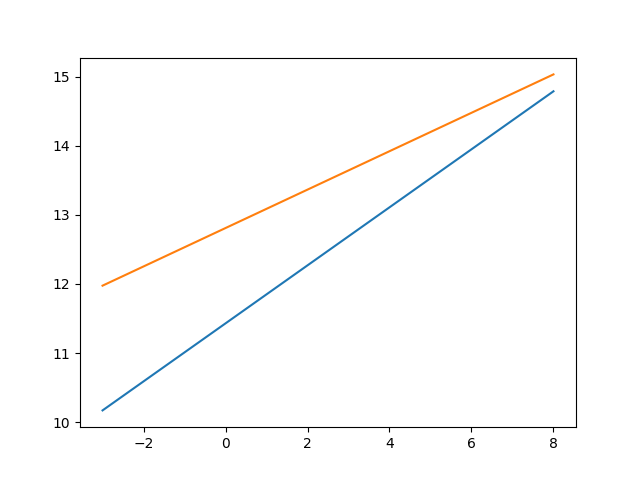

In [15]:
plt.figure()
plt.plot(np.linspace(-3, 8, 1000), powerlawlog(np.linspace(0, 8, 1000), coeff_low[0], coeff_low[1], coeff_low[2], coeff_low[3]))
plt.plot(np.linspace(-3, 8, 1000), powerlawlog(np.linspace(0, 8, 1000), coeff_high[0], coeff_high[1], coeff_high[2], coeff_high[3]))
plt.show()

In [9]:
def combine1ds(XY, A1, A2):
    x, y = XY
    return A1 * powerlawlog(x, coeff_low[0], coeff_low[1], coeff_low[2], coeff_low[3]) + A2 * powerlawlog(y, coeff_high[0], coeff_high[1], coeff_high[2], coeff_high[3])

In [10]:
datapoints2d = np.append(luminosity[:,0][np.newaxis, :], luminosity[:,1][np.newaxis, :], axis=0)
coeff2d, var = curve_fit(combine1ds, datapoints2d, mass)
print(coeff2d)

[0.50602343 0.49606005]


In [11]:
nrevals = 40

X, Y = np.meshgrid(np.linspace(2, 8, nrevals), np.linspace(0, 8, nrevals))
XY = np.append(X.flatten()[np.newaxis, :], Y.flatten()[np.newaxis, :], axis=0)
Z = combine1ds(XY, coeff2d[0], coeff2d[1]).reshape(nrevals, nrevals)

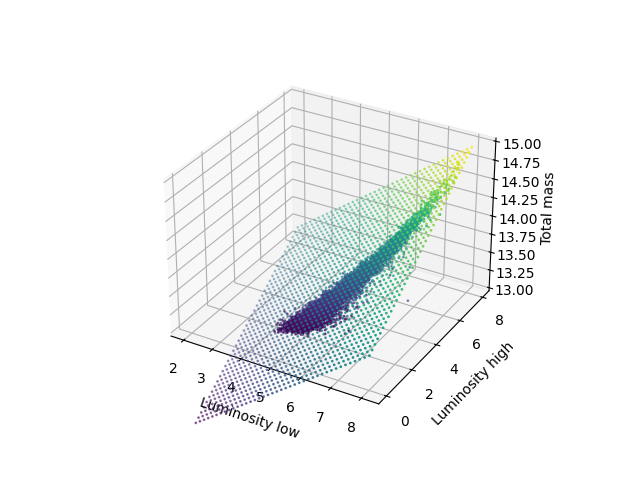

In [12]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d', alpha=0.2)
ax.scatter(X, Y, Z, s=1, c=Z)
ax.scatter(luminosity[::10,0], luminosity[::10,1], mass[::10], s=1, c=mass[::10])

ax.set_xlabel("Luminosity low")
ax.set_ylabel("Luminosity high")
ax.set_zlim(13, 15)
ax.set_zlabel("Total mass")
plt.show()

# Double Powerlaw Function

In [2]:
def power_law(L, L0, M0, p1, p2):
    return 10**M0 *((L/10**L0)**p1 + (L/10**L0)**p2)

all_coeffs = {}
from scipy.optimize import curve_fit
for model in ["HYDRO_WEAK_AGN", "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_JETS_published", "HYDRO_STRONG_JETS_published"]:
    p["model"] = model
    data = Data(p)
    print(model)

    mass = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:]
    luminosity = data.soap_file[f"{p['selection_type']}/XRayPhotonLuminosityWithoutRecentAGNHeating"][:]
    mass_selection = np.logical_and(mass > 1e13, mass < 1e15)
    nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

    selection = mass_selection*nonzero
    
    flux_ratio, fov = get_flux_ratio(p)

    mass = mass[selection]
    luminosity = luminosity[selection]*flux_ratio*p["obs_time"]

    bins = np.logspace(13, 15, 20)
    masses = np.logspace(13, 15, 39)[1::2] #log middles of bins

    luminosities_low = []
    var16_low = []
    var84_low = []
    luminosities_high = []
    var16_high = []
    var84_high = []

    for i in range(len(bins)-1):
        indices = np.logical_and(mass > bins[i], mass < bins[i+1])
        luminosities_low.append(np.median(luminosity[indices,0]))
        var16_low.append(np.percentile(luminosity[indices,0], 16))
        var84_low.append(np.percentile(luminosity[indices,0], 84))
        luminosities_high.append(np.median(luminosity[indices,1]))
        var16_high.append(np.percentile(luminosity[indices,1], 16))
        var84_high.append(np.percentile(luminosity[indices,1], 84))
    var16_low = np.array(luminosities_low) - np.array(var16_low)
    var84_low = np.array(var84_low) - np.array(luminosities_low)
    var16_high = np.array(luminosities_high) - np.array(var16_high)
    var84_high = np.array(var84_high) - np.array(luminosities_high)

    
    coeff_low, var = curve_fit(power_law, luminosities_low, masses, maxfev=3000, sigma=var16_low+var84_low, p0=[5, 13.5, 0.3, 0.7])
    print("L0, M0, p1, p2 for low energy band: ", coeff_low)
    coeff_high, var = curve_fit(power_law, luminosities_high, masses, maxfev=3000, sigma=var16_high+var84_high, p0=[5, 13.5, 0.3, 0.7])
    print("L0, M0, p1, p2 for high energy band: ", coeff_high)

    def powerlaw2d(xy, A1, A2):
        x, y = xy
        return A1*power_law(x, coeff_low[0], coeff_low[1], coeff_low[2], coeff_low[3]) + A2*power_law(y, coeff_high[0], coeff_high[1], coeff_high[2], coeff_high[3])

    datapoints2d = np.append(luminosity[:,0][np.newaxis, :], luminosity[:,1][np.newaxis, :], axis=0)
    coeff2d, var = curve_fit(powerlaw2d, datapoints2d, mass)
    print("A1, A2 for 2d: ", coeff2d)

    coeffdict = {}
    coeffdict["low"] = {}
    coeffdict["low"]["L0"] = coeff_low[0]
    coeffdict["low"]["M0"] = coeff_low[1]
    coeffdict["low"]["p1"] = coeff_low[2]
    coeffdict["low"]["p2"] = coeff_low[3]
    coeffdict["high"] = {}
    coeffdict["high"]["L0"] = coeff_high[0]
    coeffdict["high"]["M0"] = coeff_high[1]
    coeffdict["high"]["p1"] = coeff_high[2]
    coeffdict["high"]["p2"] = coeff_high[3]
    coeffdict["2d"] = {}
    coeffdict["2d"]["A1"] = coeff2d[0]
    coeffdict["2d"]["A2"] = coeff2d[1]

    all_coeffs[model] = coeffdict
import json
with open(p['model_path'] + "powerlaw_coeffs_photons.json", 'w') as filepath:
    json.dump(all_coeffs, filepath, indent=4)

HYDRO_WEAK_AGN
L0, M0, p1, p2 for low energy band:  [ 6.36318611 13.52052921  0.34271893  0.96086342]
L0, M0, p1, p2 for high energy band:  [ 5.40860142 13.66670937  0.23393908  0.74573049]
A1, A2 for 2d:  [-0.32628395  1.19488432]
HYDRO_FIDUCIAL
L0, M0, p1, p2 for low energy band:  [ 7.58664667 14.50085762  0.46655485  1.30278924]
L0, M0, p1, p2 for high energy band:  [ 6.10426412 14.08760579  0.27228326  0.83435576]
A1, A2 for 2d:  [0.31150375 0.60678389]
HYDRO_STRONG_AGN
L0, M0, p1, p2 for low energy band:  [ 7.88642386 14.82013253  0.49747913  1.67691324]
L0, M0, p1, p2 for high energy band:  [ 6.43978858 14.32151805  0.29447611  0.94666393]
A1, A2 for 2d:  [-0.39015115  1.22647872]
HYDRO_STRONGER_AGN
L0, M0, p1, p2 for low energy band:  [ 7.19401805 14.29077321  0.52233414  0.52233345]
L0, M0, p1, p2 for high energy band:  [ 6.67166759 14.50172895  0.31250829  1.07775672]
A1, A2 for 2d:  [ 1.0393275  -0.09145493]
HYDRO_STRONGEST_AGN
L0, M0, p1, p2 for low energy band:  [ 7.3770527

# Powerlaw old

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


total nr halos in selection:  80999
nr inside mass selection:  80999
nr with nonzero luminosity:  563750


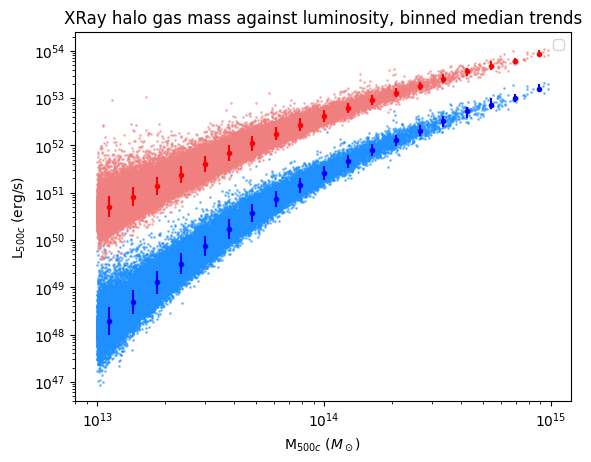

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


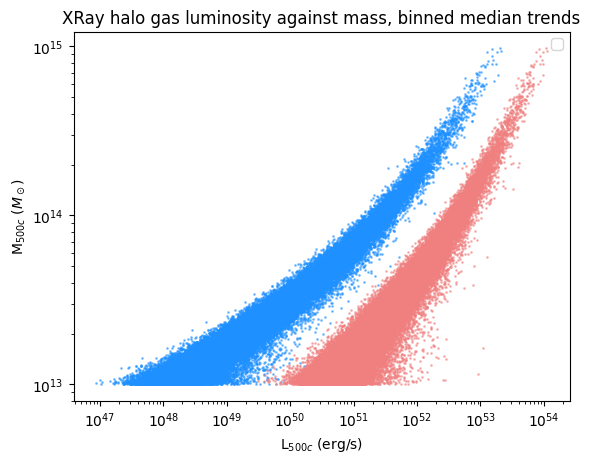

In [2]:
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)

mass = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:]
luminosity = data.soap_file[f"{p['selection_type']}/XRayPhotonLuminosityWithoutRecentAGNHeating"][:]
mass_selection = np.logical_and(mass > 1e13, mass < 1e15)
nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

selection = mass_selection*nonzero

flux_ratio, fov = get_flux_ratio(p)

mass = mass[selection]
luminosity = luminosity[selection]#*flux_ratio*p["obs_time"]
print("total nr halos in selection: ", len(mass))
print("nr inside mass selection: ", np.sum(mass_selection))
print("nr with nonzero luminosity: ", np.sum(nonzero))


bins = np.logspace(13, 15, 20)
masses = np.logspace(13, 15, 39)[1::2] #log middles of bins

luminosities_low = []
var16_low = []
var84_low = []
luminosities_high = []
var16_high = []
var84_high = []

for i in range(len(bins)-1):
    indices = np.logical_and(mass > bins[i], mass < bins[i+1])
    luminosities_low.append(np.median(luminosity[indices,0]))
    var16_low.append(np.percentile(luminosity[indices,0], 16))
    var84_low.append(np.percentile(luminosity[indices,0], 84))
    luminosities_high.append(np.median(luminosity[indices,1]))
    var16_high.append(np.percentile(luminosity[indices,1], 16))
    var84_high.append(np.percentile(luminosity[indices,1], 84))
var16_low = np.array(luminosities_low) - np.array(var16_low)
var84_low = np.array(var84_low) - np.array(luminosities_low)
var16_high = np.array(luminosities_high) - np.array(var16_high)
var84_high = np.array(var84_high) - np.array(luminosities_high)

plt.scatter(mass, luminosity[:, 1], s=1, c="dodgerblue", alpha=0.5)
plt.scatter(mass, luminosity[:, 0], s=1, c="lightcoral", alpha=0.5)
plt.errorbar(masses, luminosities_low, [var16_low, var84_low], c="red", ls="none", marker=".")
plt.errorbar(masses, luminosities_high, [var16_high, var84_high], c="blue", ls="none", marker=".")

# plt.ylim(1e-1, 1e9)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M$_{500c}$ $(M_\odot)$")
plt.ylabel("L$_{500c}$ (erg/s)")
plt.title("XRay halo gas mass against luminosity, binned median trends")
plt.legend()
plt.show()

### reverse
plt.scatter(luminosity[:, 1], mass, s=1, c="dodgerblue", alpha=0.5)
plt.scatter(luminosity[:, 0], mass, s=1, c="lightcoral", alpha=0.5)
# plt.errorbar(luminosities_low, masses, [var16_low, var84_low], c="red", ls="none", marker=".")
# plt.errorbar(luminosities_high, masses, [var16_high, var84_high], c="blue", ls="none", marker=".")

# plt.ylim(1e-1, 1e9)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("M$_{500c}$ $(M_\odot)$")
plt.xlabel("L$_{500c}$ (erg/s)")
plt.title("XRay halo gas luminosity against mass, binned median trends")
plt.legend()
plt.show()

In [3]:
# def power_law(x, A1, p1, A2, p2, c):
#     return A1*x**p1 + A2*x**p2 + c
# def power_law(x, A, b, c, m):
#     return 10**A * (x / 10**m)**b / (1 + (x/10**m)**c)

def power_law(L, L0, M0, p1, p2):
    return 10**M0 *((L/10**L0)**p1 + (L/10**L0)**p2)


/var/tmp/tol/ipykernel_2939537/492606109.py:6: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff_low, var = curve_fit(power_law, masses, luminosities_low, maxfev=3000, sigma=var16_low+var84_low, p0=[51, 13.5, 3, 1])
/var/tmp/tol/ipykernel_2939537/492606109.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff_high, var = curve_fit(power_law, masses, luminosities_high, maxfev=3000, sigma=var16_high+var84_high, p0=[50, 13.5, 3, 1])


[51.  13.5  3.   1. ]
[50.  13.5  3.   1. ]


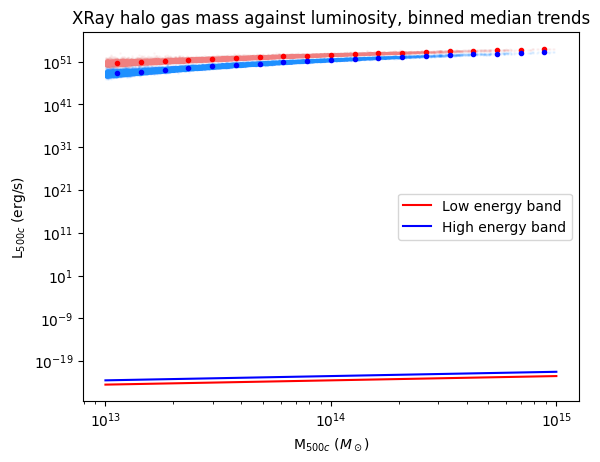

In [5]:
from scipy.optimize import curve_fit
x = np.logspace(13, 15, 100)
plt.scatter(mass, luminosity[:, 1], s=1, c="dodgerblue", alpha=0.05)
plt.scatter(mass, luminosity[:, 0], s=1, c="lightcoral", alpha=0.05)

coeff_low, var = curve_fit(power_law, masses, luminosities_low, maxfev=3000, sigma=var16_low+var84_low, p0=[51, 13.5, 3, 1])
# coeff_low, var = curve_fit(power_law, mass, luminosity[:, 0], maxfev=3000)
print(coeff_low)
plt.plot(x, power_law(x, coeff_low[0], coeff_low[1], coeff_low[2], coeff_low[3]), label="Low energy band", c="red")
coeff_high, var = curve_fit(power_law, masses, luminosities_high, maxfev=3000, sigma=var16_high+var84_high, p0=[50, 13.5, 3, 1])
# coeff_high, var = curve_fit(power_law, mass, luminosity[:, 1], maxfev=3000)
print(coeff_high)
plt.plot(x, power_law(x, coeff_high[0], coeff_high[1], coeff_high[2], coeff_high[3]), label="High energy band", c="blue")
plt.errorbar(masses, luminosities_low, [var16_low, var84_low], c="red", ls="none", marker=".")
plt.errorbar(masses, luminosities_high, [var16_high, var84_high], c="blue", ls="none", marker=".")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("M$_{500c}$ $(M_\odot)$")
plt.ylabel("L$_{500c}$ (erg/s)")
plt.title("XRay halo gas mass against luminosity, binned median trends")
plt.legend()
plt.show()

In [35]:
datapoints2d = np.append(luminosity[:,0][np.newaxis, :], luminosity[:,1][np.newaxis, :], axis=0)
def powerlaw2d(xy, A1, A2, c):
    x, y = xy
    return A1*power_law(x, coeff_low[0], coeff_low[1], coeff_low[2], coeff_low[3]) + A2*power_law(y, coeff_high[0], coeff_high[1], coeff_high[2], coeff_high[3]) + c

In [36]:
coeff2d, var = curve_fit(powerlaw2d, datapoints2d, mass)

In [2]:
# %matplotlib widget
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d', alpha=0.2)
luminosities_low = []
luminosities_high = []
luminosity = np.array([[0, 0]])
mass = np.array([0])
for model in ["HYDRO_WEAK_AGN", "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_JETS_published"]:
    p["model"] = model
    p["redshift"] = 0.15
    data = Data(p)

    mass_m = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:]
    luminosity_m = data.soap_file[f"{p['selection_type']}/XRayPhotonLuminosityWithoutRecentAGNHeating"][:,:2]
    mass_selection = np.logical_and(mass_m > 1e13, mass_m < 1e15)
    nonzero = (np.sum(luminosity_m[:,:2] == 0, axis=1) == 0)

    selection = mass_selection*nonzero

    flux_ratio, fov = get_flux_ratio(p)

    mass_m = np.log10(mass_m[selection])
    mass = np.append(mass, mass_m)
    # print(luminosity.shape)
    # print(np.log10(luminosity_m[selection]*flux_ratio*p["obs_tme"]).shape)
    luminosity = np.append(luminosity, np.log10(luminosity_m[selection]*flux_ratio*p["obs_time"]), axis=0)
    print(luminosity.shape)
    # bins = np.linspace(13, 15, 20)
    # masses = np.linspace(13, 15, 39)[1::2] #middles of bins



    # for i in range(len(bins)-1):
    #     indices = np.logical_and(mass_m > bins[i], mass_m < bins[i+1])
    #     luminosities_low.append(np.median(luminosity[indices,0]))
    #     luminosities_high.append(np.median(luminosity[indices,1]))



    # ax.scatter(luminosity[::10,0], luminosity[::10,1], mass[::10], s=1, c=mass[::10])

# ax.set_xlabel("Luminosity low")
# ax.set_ylabel("Luminosity high")
# ax.set_zlim(13, 15)
# ax.set_zlabel("Total mass")
# plt.show()

(84048, 2)
(165047, 2)
(244642, 2)
(323549, 2)
(401406, 2)
(481340, 2)
(559898, 2)
(645790, 2)
